In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import splitfolders # or import splitfolders
input_folder = "data/PlantVillage"
output = "data/PlantVillage/output/" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .3,)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 20639 files [00:14, 1459.00 files/s]


In [2]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [3]:
train_path = "data/PlantVillage/output/train"
test_path = "data/PlantVillage/output/val"

In [4]:
IMAGE_SIZE = [128,128]

In [5]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)

# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(128,128),
                                              batch_size=4,
                                              class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(128,128),
                                            batch_size=4,
                                            class_mode='categorical')

Found 14440 images belonging to 15 classes.
Found 6198 images belonging to 15 classes.


In [7]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [19]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# VGG16 with TL

In [9]:
from tensorflow.keras.applications import VGG16

In [10]:
base_model = VGG16(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model1 = Model(inputs=base_model.input, outputs=predictions)
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [11]:
hist1 = model1.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
7220/7220 [==============================] - 92s 12ms/step - loss: 2.5804 - accuracy: 0.1531 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.5685 - val_accuracy: 0.1554 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
7220/7220 [==============================] - 78s 11ms/step - loss: 2.5705 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.5659 - val_accuracy: 0.1554 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/50
7220/7220 [==============================] - 78s 11ms/step - loss: 2.5692 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.5671 - val_accuracy: 0.1554 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
7220/7220 [==============================] - 79s 11ms/step - loss: 2.5692 - accuracy: 0.1555 - f1_m: 0.0000

In [20]:
dl_acc = hist1.history["val_accuracy"][49]
dl_prec = hist1.history["val_precision_m"][49]
dl_rec = hist1.history["val_recall_m"][49]
dl_f1 = hist1.history["val_f1_m"][49]

storeResults('VGG16 with TL',dl_acc,dl_prec,dl_rec,dl_f1)

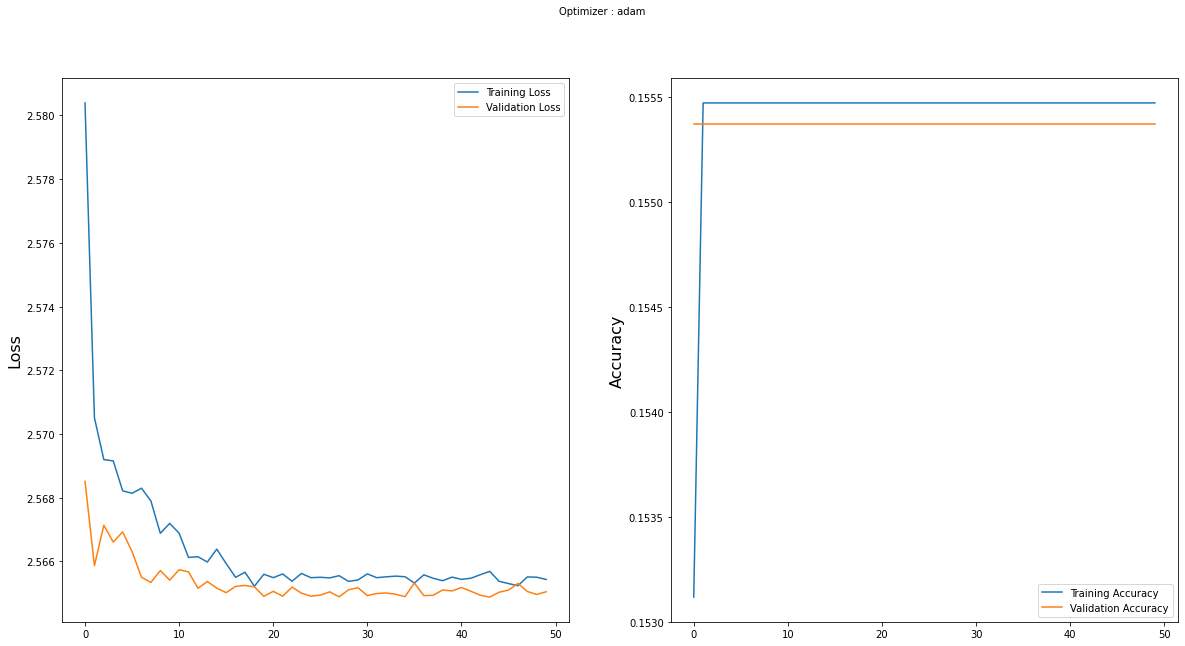

In [12]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet w/o TL

In [10]:
from tensorflow.keras.applications import DenseNet201, MobileNet, MobileNetV3Large

In [14]:
mob1 = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(mob1.output)
prediction1 = Dense(15, activation='softmax')(x1)
model2 = Model(inputs = mob1.inputs, outputs = prediction1)
model2.summary()
model2.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [15]:
hist2 = model2.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
7220/7220 [==============================] - 175s 24ms/step - loss: 1.7505 - accuracy: 0.5651 - f1_m: 0.5227 - precision_m: 0.6132 - recall_m: 0.4775 - val_loss: 0.9256 - val_accuracy: 0.7238 - val_f1_m: 0.7076 - val_precision_m: 0.7627 - val_recall_m: 0.6801
Epoch 2/50
7220/7220 [==============================] - 169s 23ms/step - loss: 1.1155 - accuracy: 0.6792 - f1_m: 0.6611 - precision_m: 0.7229 - recall_m: 0.6303 - val_loss: 1.0634 - val_accuracy: 0.6883 - val_f1_m: 0.6278 - val_precision_m: 0.7273 - val_recall_m: 0.5781
Epoch 3/50
7220/7220 [==============================] - 173s 24ms/step - loss: 0.7490 - accuracy: 0.7693 - f1_m: 0.7577 - precision_m: 0.8033 - recall_m: 0.7350 - val_loss: 0.5696 - val_accuracy: 0.8222 - val_f1_m: 0.8103 - val_precision_m: 0.8511 - val_recall_m: 0.7899
Epoch 4/50
7220/7220 [==============================] - 168s 23ms/step - loss: 0.6060 - accuracy: 0.8118 - f1_m: 0.8039 - precision_m: 0.8377 - recall_m: 0.7870 - val_loss: 0.4313 - val_a

In [21]:
dl_acc = hist2.history["val_accuracy"][49]
dl_prec = hist2.history["val_precision_m"][49]
dl_rec = hist2.history["val_recall_m"][49]
dl_f1 = hist2.history["val_f1_m"][49]

storeResults('MobileNet w/o TL',dl_acc,dl_prec,dl_rec,dl_f1)

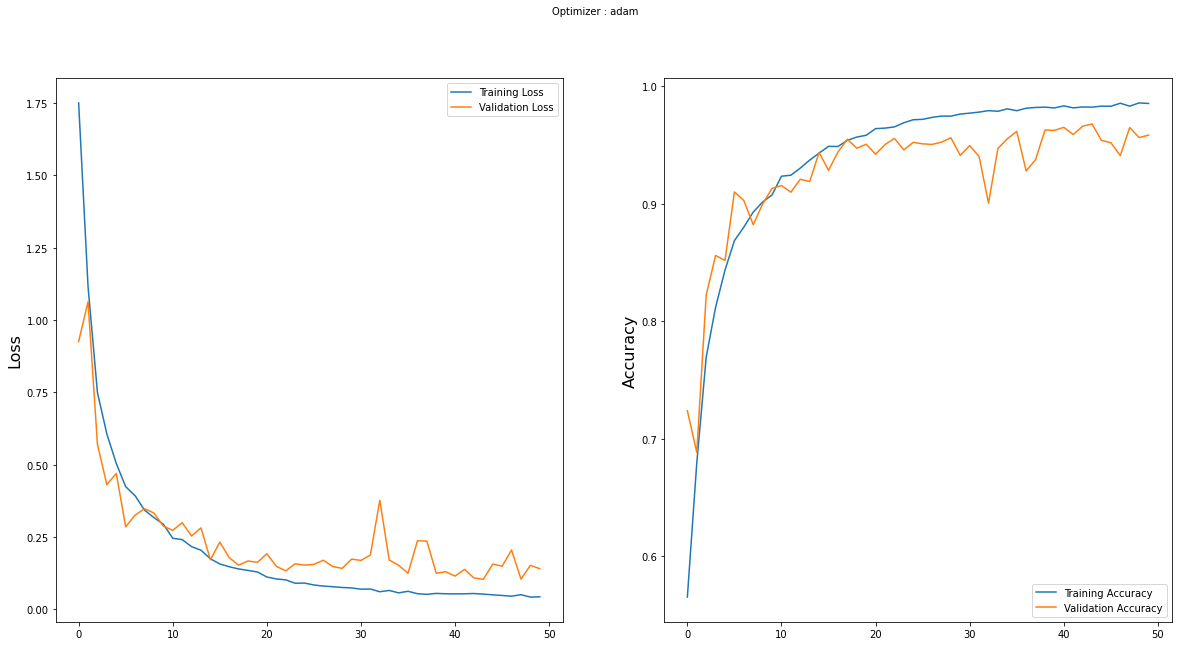

In [16]:
import matplotlib.pyplot as plt

x=hist2
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet with TL

In [17]:
base_model = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model3 = Model(inputs=base_model.input, outputs=predictions)
model3.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [18]:
hist3 = model3.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
7220/7220 [==============================] - 147s 20ms/step - loss: 1.5217 - accuracy: 0.5226 - f1_m: 0.4250 - precision_m: 0.5487 - recall_m: 0.3632 - val_loss: 0.7987 - val_accuracy: 0.7636 - val_f1_m: 0.7414 - val_precision_m: 0.8061 - val_recall_m: 0.7091
Epoch 2/50
7220/7220 [==============================] - 145s 20ms/step - loss: 0.7943 - accuracy: 0.7424 - f1_m: 0.7029 - precision_m: 0.7945 - recall_m: 0.6571 - val_loss: 0.6739 - val_accuracy: 0.7911 - val_f1_m: 0.7751 - val_precision_m: 0.8259 - val_recall_m: 0.7498
Epoch 3/50
7220/7220 [==============================] - 146s 20ms/step - loss: 0.5598 - accuracy: 0.8222 - f1_m: 0.8034 - precision_m: 0.8625 - recall_m: 0.7739 - val_loss: 0.3810 - val_accuracy: 0.8729 - val_f1_m: 0.8646 - val_precision_m: 0.8922 - val_recall_m: 0.8508
Epoch 4/50
7220/7220 [==============================] - 144s 20ms/step - loss: 0.4337 - accuracy: 0.8620 - f1_m: 0.8502 - precision_m: 0.8918 - recall_m: 0.8294 - val_loss: 0.3395 - val_a

In [22]:
dl_acc = hist3.history["val_accuracy"][49]
dl_prec = hist3.history["val_precision_m"][49]
dl_rec = hist3.history["val_recall_m"][49]
dl_f1 = hist3.history["val_f1_m"][49]

storeResults('MobileNet with TL',dl_acc,dl_prec,dl_rec,dl_f1)

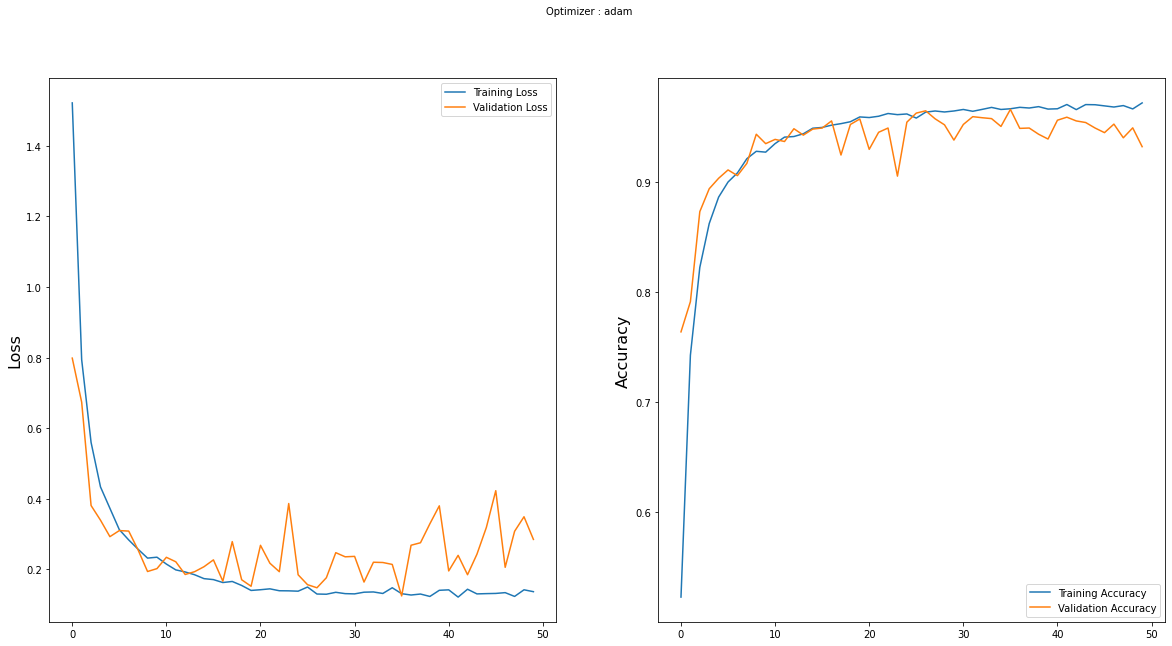

In [19]:
import matplotlib.pyplot as plt

x=hist3
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNet with StepWise TL

In [20]:
base_model = MobileNet(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model4 = Model(inputs=base_model.input, outputs=predictions)
model4.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 64, 64, 32)        0   

In [21]:
hist4 = model4.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
7220/7220 [==============================] - 208s 29ms/step - loss: 2.6064 - accuracy: 0.2717 - f1_m: 0.1627 - precision_m: 0.2313 - recall_m: 0.1284 - val_loss: 2.7968 - val_accuracy: 0.3832 - val_f1_m: 0.3509 - val_precision_m: 0.4247 - val_recall_m: 0.3140
Epoch 2/50
7220/7220 [==============================] - 202s 28ms/step - loss: 2.1683 - accuracy: 0.3068 - f1_m: 0.1852 - precision_m: 0.2739 - recall_m: 0.1409 - val_loss: 2.2983 - val_accuracy: 0.3406 - val_f1_m: 0.3181 - val_precision_m: 0.3922 - val_recall_m: 0.2811
Epoch 3/50
7220/7220 [==============================] - 196s 27ms/step - loss: 2.0254 - accuracy: 0.3517 - f1_m: 0.2323 - precision_m: 0.3390 - recall_m: 0.1790 - val_loss: 1.8705 - val_accuracy: 0.4251 - val_f1_m: 0.3542 - val_precision_m: 0.4650 - val_recall_m: 0.2988
Epoch 4/50
7220/7220 [==============================] - 196s 27ms/step - loss: 1.9089 - accuracy: 0.3921 - f1_m: 0.2705 - precision_m: 0.3891 - recall_m: 0.2112 - val_loss: 2.5133 - val_a

In [23]:
dl_acc = hist4.history["val_accuracy"][49]
dl_prec = hist4.history["val_precision_m"][49]
dl_rec = hist4.history["val_recall_m"][49]
dl_f1 = hist4.history["val_f1_m"][49]

storeResults('MobileNet with Stepwise TL',dl_acc,dl_prec,dl_rec,dl_f1)

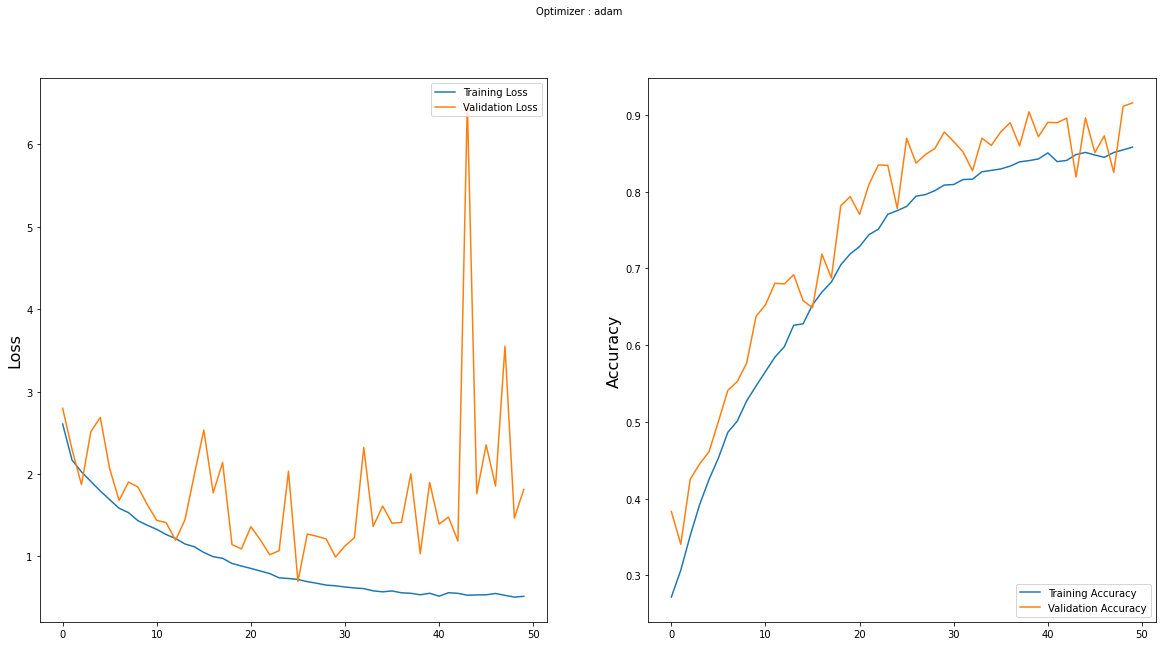

In [22]:
import matplotlib.pyplot as plt

x=hist4
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# MobileNetV3-Large with StepWise TL

In [23]:
base_model = MobileNetV3Large(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model5 = Model(inputs=base_model.input, outputs=predictions)
model5.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model5.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 64, 64, 16)   432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 64, 64, 16)   64          Conv[0][0]                       
____________________________________________________________________________________________

In [25]:
hist5 = model5.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
7220/7220 [==============================] - 869s 120ms/step - loss: 2.5655 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 73.4127 - val_accuracy: 0.1544 - val_f1_m: 0.0568 - val_precision_m: 0.0762 - val_recall_m: 0.0471
Epoch 2/50
7220/7220 [==============================] - 759s 105ms/step - loss: 2.5653 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 62.4969 - val_accuracy: 0.1552 - val_f1_m: 0.0526 - val_precision_m: 0.0720 - val_recall_m: 0.0429
Epoch 3/50
7220/7220 [==============================] - 772s 107ms/step - loss: 2.5656 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 71.5196 - val_accuracy: 0.1541 - val_f1_m: 0.0572 - val_precision_m: 0.0766 - val_recall_m: 0.0474
Epoch 4/50
7220/7220 [==============================] - 767s 106ms/step - loss: 2.5656 - accuracy: 0.1555 - f1_m: 0.0000e+00 - precision_m: 0.000

In [24]:
dl_acc = hist5.history["val_accuracy"][49]
dl_prec = hist5.history["val_precision_m"][49]
dl_rec = hist5.history["val_recall_m"][49]
dl_f1 = hist5.history["val_f1_m"][49]

storeResults('MobileNetV3-Large with StepWise TL',dl_acc,dl_prec,dl_rec,dl_f1)

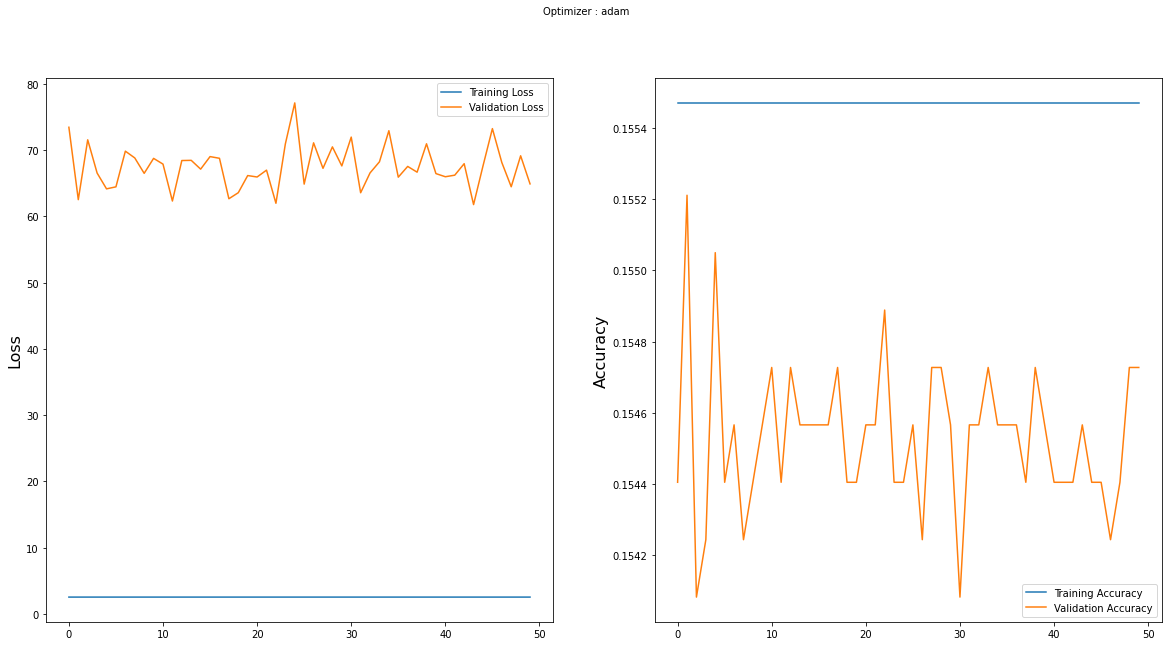

In [26]:
import matplotlib.pyplot as plt

x=hist5
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# GoogleNet

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import urllib
from tensorflow.keras.preprocessing import image

In [28]:
def inceptionnet(x,filters):
    
    #(1x1) layer
    layer1=Conv2D(filters=filters[0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    
    #(3x3) layer
    layer2=Conv2D(filters=filters[1][0],kernel_size=(1,1),strides=1,padding="same",activation="relu")(x)
    

    layer2=Conv2D(filters=filters[1][1],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer2)
    
    #(5x5) layer
    
    layer3=Conv2D(filters=filters[2][0],kernel_size=(5,5),strides=1,padding="same",activation="relu")(x)
    
    layers=Conv2D(filters=filters[2][1],kernel_size=(5,5),strides=1,padding="same",activation="relu")(layer3)
    
    
    
    layer4=MaxPooling2D(pool_size=(3,3),strides=1,padding="same")(x)
    layer4=Conv2D(filters=filters[3],kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer4)
    
    
    return Concatenate(axis=-1)([layer1,layer2,layer3,layer4])
    
    
def helperfunction(x,name=None):
    
    layer=AveragePooling2D(pool_size=(5,5),strides=3,padding="valid")(x)
    
    layer=Conv2D(filters=128,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Flatten()(layer)
    
    layer=Dense(units=255,activation="relu")(layer)
    
    layer=Dropout(0.4)(layer)
    layer=Dense(units=15,activation="softmax",name=name)(layer)
    
    return layer
    
       
def googlenet():
    
    #taking layer input
    inputlayer=Input(shape=(128,128,3))
    
    #layer_1
    layer=Conv2D(filters=64,kernel_size=(7,7),strides=1,padding="same",activation="relu")(inputlayer)
    
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    layer=BatchNormalization()(layer)
    
    #layer_2
    layer=Conv2D(filters=64,kernel_size=(1,1),strides=1,padding="same",activation="relu")(layer)
    
    layer=Conv2D(filters=192,kernel_size=(3,3),strides=1,padding="same",activation="relu")(layer)
    
    layer=BatchNormalization()(layer)
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_3
    layer=inceptionnet(layer,[64,(96,128),(16,32),32])
    layer=inceptionnet(layer,[128,(128,192),(32,96),64])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    #layer_4
    layer=inceptionnet(layer,[192,(96,208),(16,48),64])
    final_0=helperfunction(layer,name="final_layer_0")
    
    layer=inceptionnet(layer,[160,(112,224),(24,64),64])
    layer=inceptionnet(layer,[128,(128,256),(24,64),64])
    layer=inceptionnet(layer,[112,(144,288),(32,64),64])
    final_1=helperfunction(layer,name="final_layer_1")
    
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(layer)
    
    
    #layer_5
    layer=inceptionnet(layer,[256,(160,320),(32,128),128])
    layer=inceptionnet(layer,[384,(192,384),(48,128),128])
    layer=AveragePooling2D(pool_size=(7,7),strides=1,padding="same")(layer)
    
    #layer_6
    
    layer=Flatten()(layer)
    layer=Dropout(0.4)(layer)
    layer=Dense(units=256,activation="linear")(layer)
    final_2=Dense(units=15,activation="softmax",name="final_layer_2")(layer)
    
    
    model=Model(inputs=inputlayer,outputs=[final_2,final_0,final_1])
    
    return model

In [29]:
model6=googlenet()
model6.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])
model6.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 64, 64, 64)   256         max_pooling2d[0][0]              
____________________________________________________________________________________________

In [31]:
hist6 = model6.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
7220/7220 [==============================] - 952s 132ms/step - loss: 2.5328 - final_layer_2_loss: 0.9571 - final_layer_0_loss: 0.7759 - final_layer_1_loss: 0.7999 - final_layer_2_accuracy: 0.6851 - final_layer_2_f1_m: 0.6330 - final_layer_2_precision_m: 0.7310 - final_layer_2_recall_m: 0.5840 - final_layer_0_accuracy: 0.7371 - final_layer_0_f1_m: 0.7055 - final_layer_0_precision_m: 0.7839 - final_layer_0_recall_m: 0.6663 - final_layer_1_accuracy: 0.7307 - final_layer_1_f1_m: 0.6906 - final_layer_1_precision_m: 0.7788 - final_layer_1_recall_m: 0.6465 - val_loss: 3.0926 - val_final_layer_2_loss: 1.0328 - val_final_layer_0_loss: 1.0026 - val_final_layer_1_loss: 1.0572 - val_final_layer_2_accuracy: 0.6591 - val_final_layer_2_f1_m: 0.6195 - val_final_layer_2_precision_m: 0.7156 - val_final_layer_2_recall_m: 0.5715 - val_final_layer_0_accuracy: 0.7031 - val_final_layer_0_f1_m: 0.6767 - val_final_layer_0_precision_m: 0.7515 - val_final_layer_0_recall_m: 0.6392 - val_final_layer_1_a

Epoch 4/50
7220/7220 [==============================] - 884s 122ms/step - loss: 1.9512 - final_layer_2_loss: 0.7315 - final_layer_0_loss: 0.6099 - final_layer_1_loss: 0.6097 - final_layer_2_accuracy: 0.7552 - final_layer_2_f1_m: 0.7307 - final_layer_2_precision_m: 0.8028 - final_layer_2_recall_m: 0.6947 - final_layer_0_accuracy: 0.7961 - final_layer_0_f1_m: 0.7783 - final_layer_0_precision_m: 0.8355 - final_layer_0_recall_m: 0.7498 - final_layer_1_accuracy: 0.7974 - final_layer_1_f1_m: 0.7756 - final_layer_1_precision_m: 0.8373 - final_layer_1_recall_m: 0.7448 - val_loss: 1.7447 - val_final_layer_2_loss: 0.6081 - val_final_layer_0_loss: 0.6180 - val_final_layer_1_loss: 0.5186 - val_final_layer_2_accuracy: 0.7832 - val_final_layer_2_f1_m: 0.7630 - val_final_layer_2_precision_m: 0.8258 - val_final_layer_2_recall_m: 0.7317 - val_final_layer_0_accuracy: 0.8059 - val_final_layer_0_f1_m: 0.7946 - val_final_layer_0_precision_m: 0.8345 - val_final_layer_0_recall_m: 0.7746 - val_final_layer_1_a

Epoch 7/50
7220/7220 [==============================] - 895s 124ms/step - loss: 1.6851 - final_layer_2_loss: 0.6291 - final_layer_0_loss: 0.5272 - final_layer_1_loss: 0.5288 - final_layer_2_accuracy: 0.7892 - final_layer_2_f1_m: 0.7699 - final_layer_2_precision_m: 0.8283 - final_layer_2_recall_m: 0.7408 - final_layer_0_accuracy: 0.8250 - final_layer_0_f1_m: 0.8104 - final_layer_0_precision_m: 0.8532 - final_layer_0_recall_m: 0.7890 - final_layer_1_accuracy: 0.8220 - final_layer_1_f1_m: 0.8072 - final_layer_1_precision_m: 0.8542 - final_layer_1_recall_m: 0.7837 - val_loss: 2.3047 - val_final_layer_2_loss: 0.9926 - val_final_layer_0_loss: 0.6961 - val_final_layer_1_loss: 0.6161 - val_final_layer_2_accuracy: 0.7706 - val_final_layer_2_f1_m: 0.7472 - val_final_layer_2_precision_m: 0.8095 - val_final_layer_2_recall_m: 0.7160 - val_final_layer_0_accuracy: 0.8217 - val_final_layer_0_f1_m: 0.8081 - val_final_layer_0_precision_m: 0.8500 - val_final_layer_0_recall_m: 0.7872 - val_final_layer_1_a

Epoch 10/50
7220/7220 [==============================] - 851s 118ms/step - loss: 1.5692 - final_layer_2_loss: 0.6076 - final_layer_0_loss: 0.4749 - final_layer_1_loss: 0.4867 - final_layer_2_accuracy: 0.8118 - final_layer_2_f1_m: 0.7971 - final_layer_2_precision_m: 0.8445 - final_layer_2_recall_m: 0.7733 - final_layer_0_accuracy: 0.8454 - final_layer_0_f1_m: 0.8359 - final_layer_0_precision_m: 0.8722 - final_layer_0_recall_m: 0.8177 - final_layer_1_accuracy: 0.8417 - final_layer_1_f1_m: 0.8287 - final_layer_1_precision_m: 0.8682 - final_layer_1_recall_m: 0.8089 - val_loss: 1.6892 - val_final_layer_2_loss: 0.6158 - val_final_layer_0_loss: 0.5274 - val_final_layer_1_loss: 0.5460 - val_final_layer_2_accuracy: 0.7924 - val_final_layer_2_f1_m: 0.7740 - val_final_layer_2_precision_m: 0.8270 - val_final_layer_2_recall_m: 0.7475 - val_final_layer_0_accuracy: 0.8590 - val_final_layer_0_f1_m: 0.8501 - val_final_layer_0_precision_m: 0.8767 - val_final_layer_0_recall_m: 0.8367 - val_final_layer_1_

Epoch 13/50
7220/7220 [==============================] - 877s 121ms/step - loss: 1.4380 - final_layer_2_loss: 0.5475 - final_layer_0_loss: 0.4493 - final_layer_1_loss: 0.4412 - final_layer_2_accuracy: 0.8258 - final_layer_2_f1_m: 0.8122 - final_layer_2_precision_m: 0.8593 - final_layer_2_recall_m: 0.7886 - final_layer_0_accuracy: 0.8587 - final_layer_0_f1_m: 0.8479 - final_layer_0_precision_m: 0.8829 - final_layer_0_recall_m: 0.8304 - final_layer_1_accuracy: 0.8573 - final_layer_1_f1_m: 0.8478 - final_layer_1_precision_m: 0.8843 - final_layer_1_recall_m: 0.8296 - val_loss: 1.4592 - val_final_layer_2_loss: 0.4804 - val_final_layer_0_loss: 0.5289 - val_final_layer_1_loss: 0.4499 - val_final_layer_2_accuracy: 0.8580 - val_final_layer_2_f1_m: 0.8479 - val_final_layer_2_precision_m: 0.8809 - val_final_layer_2_recall_m: 0.8314 - val_final_layer_0_accuracy: 0.8830 - val_final_layer_0_f1_m: 0.8768 - val_final_layer_0_precision_m: 0.8946 - val_final_layer_0_recall_m: 0.8679 - val_final_layer_1_

Epoch 16/50
7220/7220 [==============================] - 915s 127ms/step - loss: 1.3371 - final_layer_2_loss: 0.4955 - final_layer_0_loss: 0.4258 - final_layer_1_loss: 0.4158 - final_layer_2_accuracy: 0.8357 - final_layer_2_f1_m: 0.8253 - final_layer_2_precision_m: 0.8664 - final_layer_2_recall_m: 0.8048 - final_layer_0_accuracy: 0.8657 - final_layer_0_f1_m: 0.8572 - final_layer_0_precision_m: 0.8873 - final_layer_0_recall_m: 0.8422 - final_layer_1_accuracy: 0.8656 - final_layer_1_f1_m: 0.8575 - final_layer_1_precision_m: 0.8904 - final_layer_1_recall_m: 0.8411 - val_loss: 2.3338 - val_final_layer_2_loss: 0.5918 - val_final_layer_0_loss: 1.0267 - val_final_layer_1_loss: 0.7153 - val_final_layer_2_accuracy: 0.8332 - val_final_layer_2_f1_m: 0.8137 - val_final_layer_2_precision_m: 0.8645 - val_final_layer_2_recall_m: 0.7883 - val_final_layer_0_accuracy: 0.8472 - val_final_layer_0_f1_m: 0.8318 - val_final_layer_0_precision_m: 0.8717 - val_final_layer_0_recall_m: 0.8119 - val_final_layer_1_

Epoch 19/50
7220/7220 [==============================] - 873s 121ms/step - loss: 1.2779 - final_layer_2_loss: 0.4749 - final_layer_0_loss: 0.4108 - final_layer_1_loss: 0.3922 - final_layer_2_accuracy: 0.8470 - final_layer_2_f1_m: 0.8367 - final_layer_2_precision_m: 0.8735 - final_layer_2_recall_m: 0.8184 - final_layer_0_accuracy: 0.8728 - final_layer_0_f1_m: 0.8643 - final_layer_0_precision_m: 0.8934 - final_layer_0_recall_m: 0.8498 - final_layer_1_accuracy: 0.8769 - final_layer_1_f1_m: 0.8659 - final_layer_1_precision_m: 0.8944 - final_layer_1_recall_m: 0.8517 - val_loss: 1.9591 - val_final_layer_2_loss: 0.5687 - val_final_layer_0_loss: 0.8165 - val_final_layer_1_loss: 0.5740 - val_final_layer_2_accuracy: 0.8353 - val_final_layer_2_f1_m: 0.8240 - val_final_layer_2_precision_m: 0.8604 - val_final_layer_2_recall_m: 0.8057 - val_final_layer_0_accuracy: 0.8640 - val_final_layer_0_f1_m: 0.8596 - val_final_layer_0_precision_m: 0.8772 - val_final_layer_0_recall_m: 0.8508 - val_final_layer_1_

Epoch 22/50
7220/7220 [==============================] - 841s 116ms/step - loss: 1.2426 - final_layer_2_loss: 0.4501 - final_layer_0_loss: 0.4016 - final_layer_1_loss: 0.3909 - final_layer_2_accuracy: 0.8527 - final_layer_2_f1_m: 0.8439 - final_layer_2_precision_m: 0.8789 - final_layer_2_recall_m: 0.8264 - final_layer_0_accuracy: 0.8758 - final_layer_0_f1_m: 0.8688 - final_layer_0_precision_m: 0.8969 - final_layer_0_recall_m: 0.8548 - final_layer_1_accuracy: 0.8790 - final_layer_1_f1_m: 0.8701 - final_layer_1_precision_m: 0.8989 - final_layer_1_recall_m: 0.8557 - val_loss: 5.7519 - val_final_layer_2_loss: 1.7660 - val_final_layer_0_loss: 2.0372 - val_final_layer_1_loss: 1.9487 - val_final_layer_2_accuracy: 0.5897 - val_final_layer_2_f1_m: 0.5700 - val_final_layer_2_precision_m: 0.6313 - val_final_layer_2_recall_m: 0.5394 - val_final_layer_0_accuracy: 0.6252 - val_final_layer_0_f1_m: 0.6100 - val_final_layer_0_precision_m: 0.6599 - val_final_layer_0_recall_m: 0.5850 - val_final_layer_1_

Epoch 27/50
7220/7220 [==============================] - 876s 121ms/step - loss: 1.2534 - final_layer_2_loss: 0.4570 - final_layer_0_loss: 0.4157 - final_layer_1_loss: 0.3807 - final_layer_2_accuracy: 0.8561 - final_layer_2_f1_m: 0.8466 - final_layer_2_precision_m: 0.8800 - final_layer_2_recall_m: 0.8298 - final_layer_0_accuracy: 0.8752 - final_layer_0_f1_m: 0.8656 - final_layer_0_precision_m: 0.8963 - final_layer_0_recall_m: 0.8502 - final_layer_1_accuracy: 0.8765 - final_layer_1_f1_m: 0.8691 - final_layer_1_precision_m: 0.8990 - final_layer_1_recall_m: 0.8542 - val_loss: 3.2123 - val_final_layer_2_loss: 0.8367 - val_final_layer_0_loss: 1.1268 - val_final_layer_1_loss: 1.2487 - val_final_layer_2_accuracy: 0.8198 - val_final_layer_2_f1_m: 0.8106 - val_final_layer_2_precision_m: 0.8398 - val_final_layer_2_recall_m: 0.7961 - val_final_layer_0_accuracy: 0.8672 - val_final_layer_0_f1_m: 0.8634 - val_final_layer_0_precision_m: 0.8790 - val_final_layer_0_recall_m: 0.8556 - val_final_layer_1_

Epoch 30/50
7220/7220 [==============================] - 909s 126ms/step - loss: 1.2626 - final_layer_2_loss: 0.4547 - final_layer_0_loss: 0.4095 - final_layer_1_loss: 0.3985 - final_layer_2_accuracy: 0.8546 - final_layer_2_f1_m: 0.8449 - final_layer_2_precision_m: 0.8790 - final_layer_2_recall_m: 0.8279 - final_layer_0_accuracy: 0.8730 - final_layer_0_f1_m: 0.8660 - final_layer_0_precision_m: 0.8940 - final_layer_0_recall_m: 0.8520 - final_layer_1_accuracy: 0.8799 - final_layer_1_f1_m: 0.8719 - final_layer_1_precision_m: 0.9011 - final_layer_1_recall_m: 0.8573 - val_loss: 1.8977 - val_final_layer_2_loss: 0.5270 - val_final_layer_0_loss: 0.6575 - val_final_layer_1_loss: 0.7133 - val_final_layer_2_accuracy: 0.8662 - val_final_layer_2_f1_m: 0.8568 - val_final_layer_2_precision_m: 0.8832 - val_final_layer_2_recall_m: 0.8437 - val_final_layer_0_accuracy: 0.8906 - val_final_layer_0_f1_m: 0.8823 - val_final_layer_0_precision_m: 0.9053 - val_final_layer_0_recall_m: 0.8708 - val_final_layer_1_

7220/7220 [==============================] - 401s 56ms/step - loss: 1.2410 - final_layer_2_loss: 0.4284 - final_layer_0_loss: 0.4179 - final_layer_1_loss: 0.3947 - final_layer_2_accuracy: 0.8641 - final_layer_2_f1_m: 0.8545 - final_layer_2_precision_m: 0.8865 - final_layer_2_recall_m: 0.8384 - final_layer_0_accuracy: 0.8763 - final_layer_0_f1_m: 0.8689 - final_layer_0_precision_m: 0.8966 - final_layer_0_recall_m: 0.8550 - final_layer_1_accuracy: 0.8827 - final_layer_1_f1_m: 0.8737 - final_layer_1_precision_m: 0.9020 - final_layer_1_recall_m: 0.8595 - val_loss: 1.6150 - val_final_layer_2_loss: 0.4581 - val_final_layer_0_loss: 0.6835 - val_final_layer_1_loss: 0.4735 - val_final_layer_2_accuracy: 0.8614 - val_final_layer_2_f1_m: 0.8526 - val_final_layer_2_precision_m: 0.8863 - val_final_layer_2_recall_m: 0.8358 - val_final_layer_0_accuracy: 0.8585 - val_final_layer_0_f1_m: 0.8550 - val_final_layer_0_precision_m: 0.8693 - val_final_layer_0_recall_m: 0.8479 - val_final_layer_1_accuracy: 0.8

7220/7220 [==============================] - 400s 55ms/step - loss: 1.1925 - final_layer_2_loss: 0.4211 - final_layer_0_loss: 0.4136 - final_layer_1_loss: 0.3578 - final_layer_2_accuracy: 0.8654 - final_layer_2_f1_m: 0.8579 - final_layer_2_precision_m: 0.8889 - final_layer_2_recall_m: 0.8424 - final_layer_0_accuracy: 0.8755 - final_layer_0_f1_m: 0.8700 - final_layer_0_precision_m: 0.8976 - final_layer_0_recall_m: 0.8562 - final_layer_1_accuracy: 0.8877 - final_layer_1_f1_m: 0.8792 - final_layer_1_precision_m: 0.9075 - final_layer_1_recall_m: 0.8650 - val_loss: 2.4311 - val_final_layer_2_loss: 0.6384 - val_final_layer_0_loss: 1.0822 - val_final_layer_1_loss: 0.7105 - val_final_layer_2_accuracy: 0.8106 - val_final_layer_2_f1_m: 0.8011 - val_final_layer_2_precision_m: 0.8399 - val_final_layer_2_recall_m: 0.7817 - val_final_layer_0_accuracy: 0.8540 - val_final_layer_0_f1_m: 0.8484 - val_final_layer_0_precision_m: 0.8711 - val_final_layer_0_recall_m: 0.8370 - val_final_layer_1_accuracy: 0.8

7220/7220 [==============================] - 401s 56ms/step - loss: 1.2531 - final_layer_2_loss: 0.4386 - final_layer_0_loss: 0.4228 - final_layer_1_loss: 0.3917 - final_layer_2_accuracy: 0.8587 - final_layer_2_f1_m: 0.8502 - final_layer_2_precision_m: 0.8815 - final_layer_2_recall_m: 0.8345 - final_layer_0_accuracy: 0.8711 - final_layer_0_f1_m: 0.8643 - final_layer_0_precision_m: 0.8936 - final_layer_0_recall_m: 0.8497 - final_layer_1_accuracy: 0.8796 - final_layer_1_f1_m: 0.8701 - final_layer_1_precision_m: 0.9017 - final_layer_1_recall_m: 0.8542 - val_loss: 1.2605 - val_final_layer_2_loss: 0.4662 - val_final_layer_0_loss: 0.4044 - val_final_layer_1_loss: 0.3898 - val_final_layer_2_accuracy: 0.8813 - val_final_layer_2_f1_m: 0.8758 - val_final_layer_2_precision_m: 0.8946 - val_final_layer_2_recall_m: 0.8664 - val_final_layer_0_accuracy: 0.8953 - val_final_layer_0_f1_m: 0.8905 - val_final_layer_0_precision_m: 0.9113 - val_final_layer_0_recall_m: 0.8801 - val_final_layer_1_accuracy: 0.8

7220/7220 [==============================] - 404s 56ms/step - loss: 1.4897 - final_layer_2_loss: 0.6077 - final_layer_0_loss: 0.4421 - final_layer_1_loss: 0.4398 - final_layer_2_accuracy: 0.8539 - final_layer_2_f1_m: 0.8448 - final_layer_2_precision_m: 0.8799 - final_layer_2_recall_m: 0.8273 - final_layer_0_accuracy: 0.8707 - final_layer_0_f1_m: 0.8601 - final_layer_0_precision_m: 0.8929 - final_layer_0_recall_m: 0.8438 - final_layer_1_accuracy: 0.8711 - final_layer_1_f1_m: 0.8622 - final_layer_1_precision_m: 0.8947 - final_layer_1_recall_m: 0.8460 - val_loss: 1.9904 - val_final_layer_2_loss: 0.5405 - val_final_layer_0_loss: 0.9604 - val_final_layer_1_loss: 0.4896 - val_final_layer_2_accuracy: 0.8574 - val_final_layer_2_f1_m: 0.8512 - val_final_layer_2_precision_m: 0.8772 - val_final_layer_2_recall_m: 0.8382 - val_final_layer_0_accuracy: 0.9046 - val_final_layer_0_f1_m: 0.9013 - val_final_layer_0_precision_m: 0.9138 - val_final_layer_0_recall_m: 0.8950 - val_final_layer_1_accuracy: 0.8

7220/7220 [==============================] - 401s 56ms/step - loss: 1.2184 - final_layer_2_loss: 0.4249 - final_layer_0_loss: 0.3996 - final_layer_1_loss: 0.3938 - final_layer_2_accuracy: 0.8643 - final_layer_2_f1_m: 0.8546 - final_layer_2_precision_m: 0.8882 - final_layer_2_recall_m: 0.8377 - final_layer_0_accuracy: 0.8780 - final_layer_0_f1_m: 0.8683 - final_layer_0_precision_m: 0.8976 - final_layer_0_recall_m: 0.8537 - final_layer_1_accuracy: 0.8794 - final_layer_1_f1_m: 0.8696 - final_layer_1_precision_m: 0.9008 - final_layer_1_recall_m: 0.8539 - val_loss: 2.2892 - val_final_layer_2_loss: 0.6177 - val_final_layer_0_loss: 0.6551 - val_final_layer_1_loss: 1.0164 - val_final_layer_2_accuracy: 0.8816 - val_final_layer_2_f1_m: 0.8778 - val_final_layer_2_precision_m: 0.8972 - val_final_layer_2_recall_m: 0.8680 - val_final_layer_0_accuracy: 0.9087 - val_final_layer_0_f1_m: 0.9035 - val_final_layer_0_precision_m: 0.9230 - val_final_layer_0_recall_m: 0.8937 - val_final_layer_1_accuracy: 0.8

7220/7220 [==============================] - 402s 56ms/step - loss: 1.1951 - final_layer_2_loss: 0.4114 - final_layer_0_loss: 0.4021 - final_layer_1_loss: 0.3816 - final_layer_2_accuracy: 0.8704 - final_layer_2_f1_m: 0.8611 - final_layer_2_precision_m: 0.8897 - final_layer_2_recall_m: 0.8468 - final_layer_0_accuracy: 0.8789 - final_layer_0_f1_m: 0.8724 - final_layer_0_precision_m: 0.9003 - final_layer_0_recall_m: 0.8584 - final_layer_1_accuracy: 0.8818 - final_layer_1_f1_m: 0.8726 - final_layer_1_precision_m: 0.9016 - final_layer_1_recall_m: 0.8582 - val_loss: 1.3087 - val_final_layer_2_loss: 0.4500 - val_final_layer_0_loss: 0.4557 - val_final_layer_1_loss: 0.4031 - val_final_layer_2_accuracy: 0.8593 - val_final_layer_2_f1_m: 0.8544 - val_final_layer_2_precision_m: 0.8832 - val_final_layer_2_recall_m: 0.8399 - val_final_layer_0_accuracy: 0.8948 - val_final_layer_0_f1_m: 0.8910 - val_final_layer_0_precision_m: 0.9087 - val_final_layer_0_recall_m: 0.8822 - val_final_layer_1_accuracy: 0.8

In [32]:
goo_acc = hist6.history["val_final_layer_1_accuracy"][49]
goo_prec = hist6.history["val_final_layer_1_precision_m"][49]
goo_rec = hist6.history["val_final_layer_1_recall_m"][49]
goo_f1 = hist6.history["val_final_layer_1_f1_m"][49]

In [25]:
storeResults('GoogleNet',goo_acc,goo_prec,goo_rec,goo_f1)

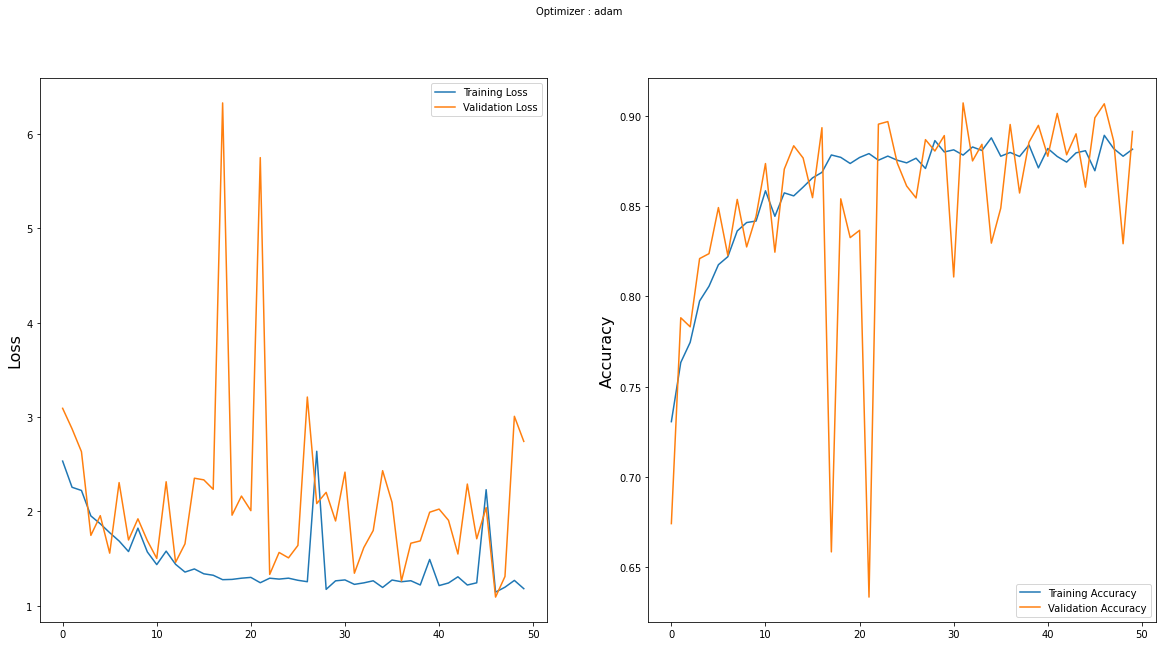

In [33]:
import matplotlib.pyplot as plt

x=hist6
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['final_layer_1_accuracy'], label='Training Accuracy')
plt.plot(x.history['val_final_layer_1_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# AlexNet

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

In [35]:
np.random.seed(1000)

#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(128,128,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())
# 1st Fully Connected Layer
AlexNet.add(Dense(4096, input_shape=(32,32,3,)))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1000))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(15))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_59 (Conv2D)           (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0

In [36]:
AlexNet.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

In [37]:
hist7 = AlexNet.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
7220/7220 [==============================] - 135s 18ms/step - loss: 2.6474 - accuracy: 0.1382 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.5628 - val_accuracy: 0.1538 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/50
7220/7220 [==============================] - 133s 18ms/step - loss: 2.5402 - accuracy: 0.1502 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.4435 - val_accuracy: 0.1994 - val_f1_m: 0.0027 - val_precision_m: 0.0040 - val_recall_m: 0.0021
Epoch 3/50
7220/7220 [==============================] - 135s 19ms/step - loss: 2.5565 - accuracy: 0.1536 - f1_m: 0.0000e+00 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00 - val_loss: 2.5346 - val_accuracy: 0.1820 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/50
7220/7220 [==============================] - 136s 19ms/step - loss: 2.5462 - accuracy: 0.1461 - f1_m: 0.0000e+00 - p

In [26]:
dl_acc = hist7.history["val_accuracy"][11]
dl_prec = hist7.history["val_precision_m"][11]
dl_rec = hist7.history["val_recall_m"][11]
dl_f1 = hist7.history["val_f1_m"][11]

storeResults('AlexNet',dl_acc,dl_prec,dl_rec,dl_f1)

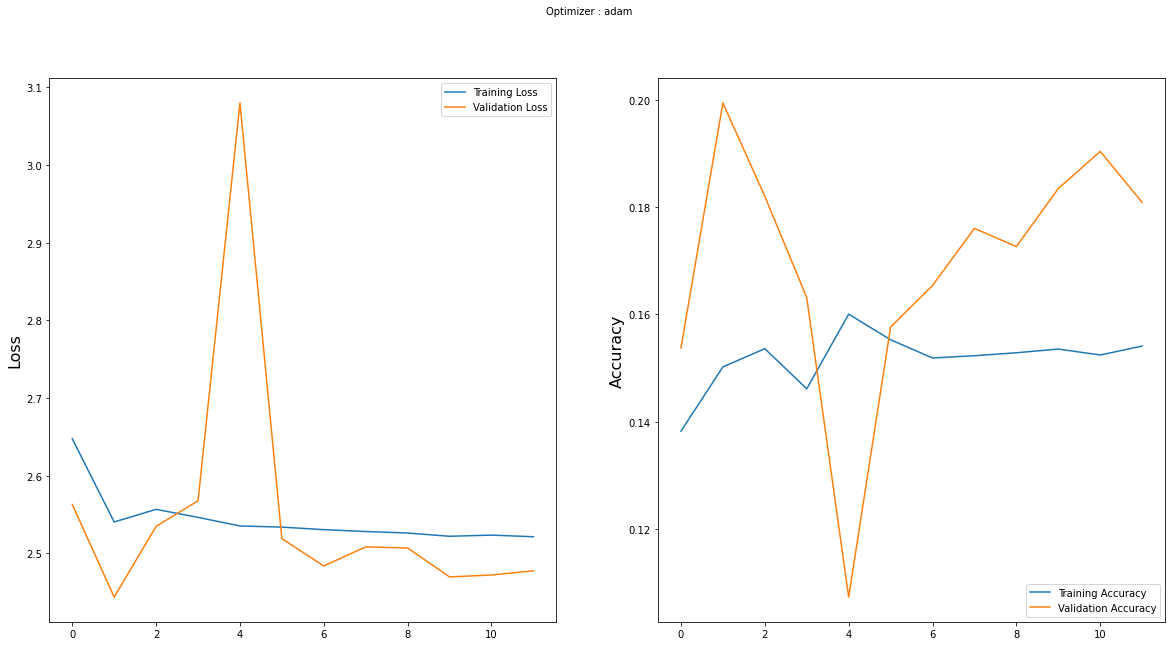

In [38]:
import matplotlib.pyplot as plt

x=hist7
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# DenseNet

In [11]:
des201=DenseNet201(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

x1= Flatten()(des201.output)
prediction1 = Dense(15, activation='softmax')(x1)
model8 = Model(inputs = des201.inputs, outputs = prediction1)
model8.summary()
model8.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [12]:
hist8 = model8.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/50
3610/3610 [==============================] - 447s 119ms/step - loss: 2.8082 - accuracy: 0.4196 - f1_m: 0.3844 - precision_m: 0.5013 - recall_m: 0.3282 - val_loss: 2.0365 - val_accuracy: 0.6246 - val_f1_m: 0.6136 - val_precision_m: 0.6935 - val_recall_m: 0.5661
Epoch 2/50
3610/3610 [==============================] - 419s 116ms/step - loss: 0.9031 - accuracy: 0.6988 - f1_m: 0.6794 - precision_m: 0.7853 - recall_m: 0.6186 - val_loss: 5.3690 - val_accuracy: 0.5979 - val_f1_m: 0.5822 - val_precision_m: 0.6667 - val_recall_m: 0.5332
Epoch 3/50
3610/3610 [==============================] - 431s 119ms/step - loss: 0.6769 - accuracy: 0.7683 - f1_m: 0.7586 - precision_m: 0.8270 - recall_m: 0.7152 - val_loss: 0.7019 - val_accuracy: 0.7819 - val_f1_m: 0.7751 - val_precision_m: 0.8186 - val_recall_m: 0.7456
Epoch 4/50
3610/3610 [==============================] - 424s 117ms/step - loss: 0.5443 - accuracy: 0.8224 - f1_m: 0.8149 - precision_m: 0.8610 - recall_m: 0.7838 - val_loss: 156.4506 -

3610/3610 [==============================] - 333s 92ms/step - loss: 0.0219 - accuracy: 0.9931 - f1_m: 0.9930 - precision_m: 0.9934 - recall_m: 0.9927 - val_loss: 0.1183 - val_accuracy: 0.9677 - val_f1_m: 0.9672 - val_precision_m: 0.9682 - val_recall_m: 0.9665
Epoch 31/50
3610/3610 [==============================] - 333s 92ms/step - loss: 0.0229 - accuracy: 0.9926 - f1_m: 0.9923 - precision_m: 0.9929 - recall_m: 0.9918 - val_loss: 0.1191 - val_accuracy: 0.9672 - val_f1_m: 0.9677 - val_precision_m: 0.9692 - val_recall_m: 0.9666

Epoch 00031: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 32/50
3610/3610 [==============================] - 333s 92ms/step - loss: 0.0187 - accuracy: 0.9945 - f1_m: 0.9944 - precision_m: 0.9950 - recall_m: 0.9940 - val_loss: 0.1057 - val_accuracy: 0.9719 - val_f1_m: 0.9720 - val_precision_m: 0.9726 - val_recall_m: 0.9716
Epoch 33/50
3610/3610 [==============================] - 333s 92ms/step - loss: 0.0150 - accuracy: 0.9954 - f1_m: 0

In [27]:
dl_acc = hist8.history["val_accuracy"][45]
dl_prec = hist8.history["val_precision_m"][45]
dl_rec = hist8.history["val_recall_m"][45]
dl_f1 = hist8.history["val_f1_m"][45]

storeResults('DenseNet',dl_acc,dl_prec,dl_rec,dl_f1)

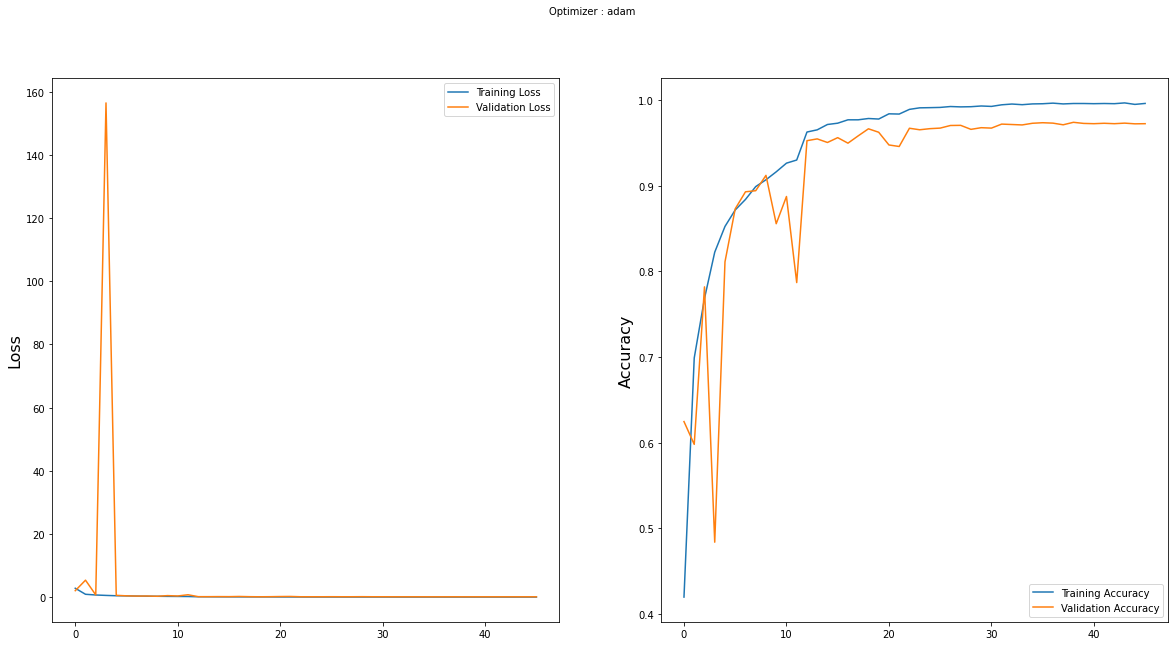

In [13]:
import matplotlib.pyplot as plt

x=hist8
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Xception

In [14]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Activation, Dense,GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

In [15]:
base_model = Xception(input_shape = IMAGE_SIZE + [3],weights='imagenet', include_top=False )

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(15, activation='softmax')(x)

# this is the model we will train
model9 = Model(inputs=base_model.input, outputs=predictions)
model9.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=["accuracy",f1_m,precision_m, recall_m])
model9.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [16]:
hist9 = model9.fit(train_set, validation_data=test_set, epochs=50, steps_per_epoch=len(train_set), validation_steps=len(test_set))

Epoch 1/50
1550/1550 [==============================] - 46s 28ms/step - loss: 1.4639 - accuracy: 0.5423 - f1_m: 0.4453 - precision_m: 0.6572 - recall_m: 0.3621 - val_loss: 0.3273 - val_accuracy: 0.9008 - val_f1_m: 0.8858 - val_precision_m: 0.9395 - val_recall_m: 0.8500
Epoch 2/50
1550/1550 [==============================] - 43s 28ms/step - loss: 0.5997 - accuracy: 0.8125 - f1_m: 0.8014 - precision_m: 0.8843 - recall_m: 0.7503 - val_loss: 0.0850 - val_accuracy: 0.9726 - val_f1_m: 0.9726 - val_precision_m: 0.9789 - val_recall_m: 0.9681
Epoch 3/50
1550/1550 [==============================] - 44s 28ms/step - loss: 0.3709 - accuracy: 0.8896 - f1_m: 0.8855 - precision_m: 0.9263 - recall_m: 0.8577 - val_loss: 0.0470 - val_accuracy: 0.9906 - val_f1_m: 0.9866 - val_precision_m: 0.9929 - val_recall_m: 0.9819
Epoch 4/50
1550/1550 [==============================] - 43s 28ms/step - loss: 0.2440 - accuracy: 0.9271 - f1_m: 0.9212 - precision_m: 0.9462 - recall_m: 0.9035 - val_loss: 0.1050 - val_accur

1550/1550 [==============================] - 44s 28ms/step - loss: 0.0124 - accuracy: 0.9968 - f1_m: 0.9966 - precision_m: 0.9970 - recall_m: 0.9963 - val_loss: 0.0210 - val_accuracy: 0.9994 - val_f1_m: 0.9946 - val_precision_m: 0.9998 - val_recall_m: 0.9906
Epoch 32/50
1550/1550 [==============================] - 44s 28ms/step - loss: 0.0094 - accuracy: 0.9979 - f1_m: 0.9980 - precision_m: 0.9985 - recall_m: 0.9976 - val_loss: 0.0303 - val_accuracy: 0.9971 - val_f1_m: 0.9911 - val_precision_m: 0.9992 - val_recall_m: 0.9852
Epoch 33/50
1550/1550 [==============================] - 44s 28ms/step - loss: 0.0102 - accuracy: 0.9968 - f1_m: 0.9969 - precision_m: 0.9975 - recall_m: 0.9965 - val_loss: 0.0168 - val_accuracy: 0.9977 - val_f1_m: 0.9951 - val_precision_m: 0.9984 - val_recall_m: 0.9926
Epoch 34/50
1550/1550 [==============================] - 44s 29ms/step - loss: 0.0095 - accuracy: 0.9977 - f1_m: 0.9977 - precision_m: 0.9980 - recall_m: 0.9974 - val_loss: 0.0130 - val_accuracy: 0.9

In [28]:
dl_acc = hist9.history["val_accuracy"][49]
dl_prec = hist9.history["val_precision_m"][49]
dl_rec = hist9.history["val_recall_m"][49]
dl_f1 = hist9.history["val_f1_m"][49]

storeResults('Xception',dl_acc,dl_prec,dl_rec,dl_f1)

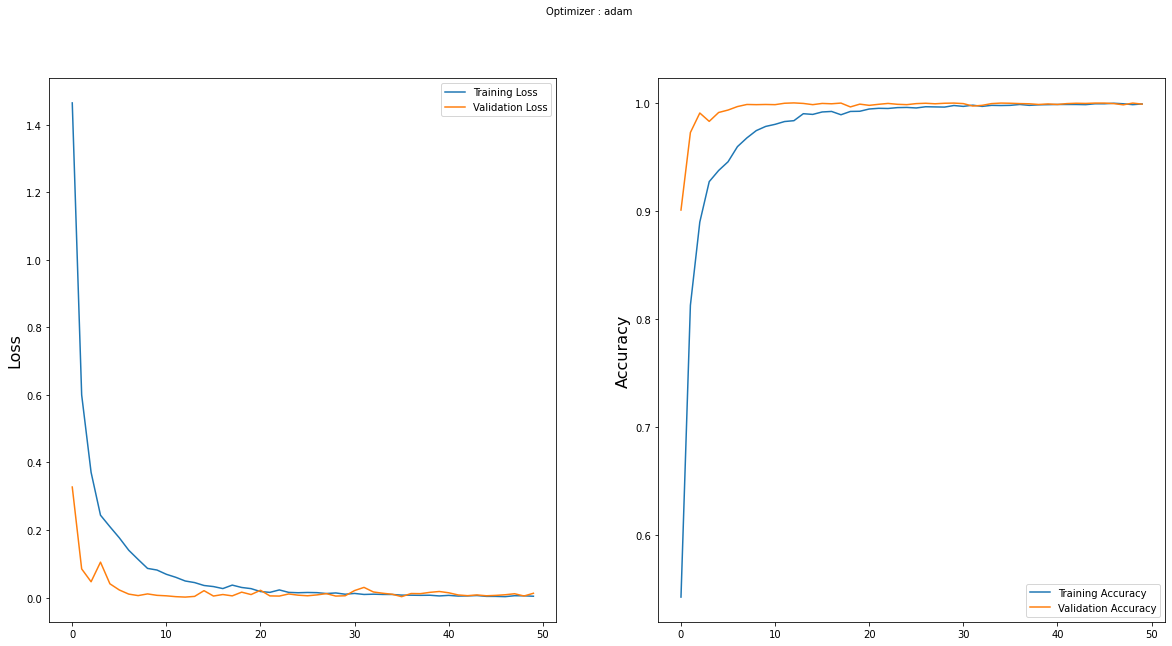

In [18]:
import matplotlib.pyplot as plt

x=hist9
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

# Comparison

In [29]:
#creating dataframe
import pandas as pd
result = pd.DataFrame({ 'ML Model' : ML_Model,
                        'Accuracy' : accuracy,
                        'Precision': precision,
                        'Recall'   : recall,
                        'F1-Score': f1score,
                        
                      })

In [30]:
result

,ML Model,Accuracy,Precision,Recall,F1-Score
0,VGG16 with TL,0.155,0.155,0.155,0.155
1,MobileNet w/o TL,0.959,0.960,0.955,0.957
2,MobileNet with TL,0.932,0.941,0.928,0.933
3,MobileNet with Stepwise TL,0.916,0.918,0.915,0.916
4,MobileNetV3-Large with StepWise TL,0.155,0.155,0.155,0.155
5,GoogleNet,0.891,0.906,0.877,0.886
6,AlexNet,0.181,0.181,0.181,0.181
7,DenseNet,0.972,0.974,0.971,0.972
8,Xception,0.999,1.000,0.993,0.996


# Modelling

In [31]:
model9.save('plantvill.h5')

# Graph

In [32]:
classifier = ML_Model
y_pos = np.arange(len(classifier))

# Accuracy

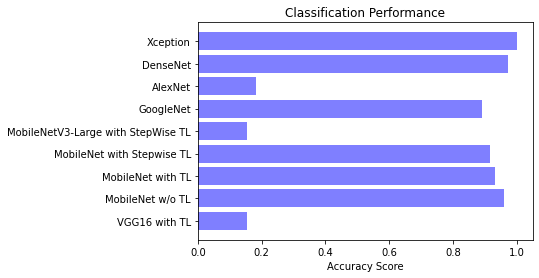

In [33]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, accuracy, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Accuracy Score')
plt2.title('Classification Performance')
plt2.show()

# Precision

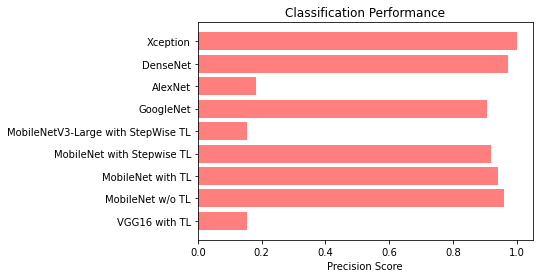

In [34]:
plt2.barh(y_pos, precision, align='center', alpha=0.5,color='red')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Precision Score')
plt2.title('Classification Performance')
plt2.show()

# Recall

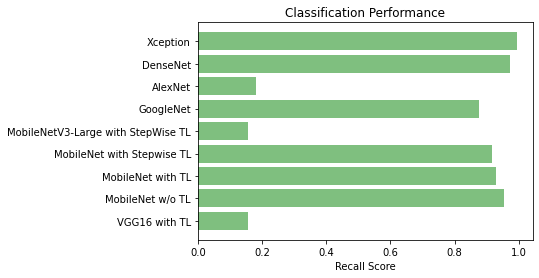

In [35]:
plt2.barh(y_pos, recall, align='center', alpha=0.5,color='green')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Recall Score')
plt2.title('Classification Performance')
plt2.show()

# F1 Score

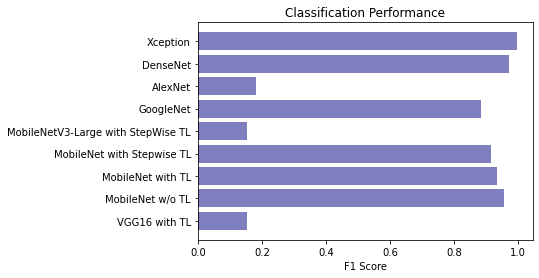

In [36]:
plt2.barh(y_pos, f1score, align='center', alpha=0.5,color='navy')
plt2.yticks(y_pos, classifier)
plt2.xlabel('F1 Score')
plt2.title('Classification Performance')
plt2.show()